In [2]:
# ============================================================
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from scipy import stats
# Charger votre dataset
data = pd.read_excel(r'C:\Users\stude\OneDrive\Bureau\these_version_ultime\data_complet(reg).xlsx')

# Créer la nouvelle colonne binaire
data['Antécédants familiaux_histoire modérée'] = 0

# La colonne prend la valeur 1 seulement quand les deux colonnes précédentes sont à 0
data.loc[(data['Antécédants familiaux_amsterdam II'] == 0) & 
       (data['Antécédants familiaux_pas d\'histoire'] == 0), 
       'Antécédants familiaux_histoire modérée'] = 1

data.drop(columns= ['Antécédants familiaux_amsterdam II',"femme","IHC MMR_M1/P2","IHC MMR_P2"], inplace=True)
data.head()

# Créer une variable simplifiée avec une seule modalité pour les multiples
data['type_tumeur_simplifie'] = 'autre_tumeur'

# Dès qu'un cancer multiple est détecté → catégorie "multiples"
data.loc[data['cancer multiples'] == 1, 'type_tumeur_simplifie'] = 'multiples'

# Pour les tumeurs uniques, on précise le type
data.loc[(data['cancer multiples'] == 0) & (data['tumeur colorectal'] == 1), 'type_tumeur_simplifie'] = 'colon_seul'
data.loc[(data['cancer multiples'] == 0) & (data['tumeur endometrial'] == 1), 'type_tumeur_simplifie'] = 'endo_seul'


# Supprimer les colonnes inutiles
data = data.drop(columns=['tumeur endometrial', 'tumeur colorectal', 'cancer multiples'])

# Encodage one-hot
data_encoded = pd.get_dummies(data, columns=['type_tumeur_simplifie'], drop_first=True)

# Conversion des colonnes en float
for col in data_encoded.columns:
    data_encoded[col] = data_encoded[col].astype(float)


# ============================================================
# 2. DÉFINITION DES VARIABLES X ET Y
# ============================================================
X = data_encoded.drop(columns=["muté/methylé"])
y = data_encoded["muté/methylé"]

# ============================================================
# 3. RÉGRESSION LOGISTIQUE AVEC RÉGULARISATION (L1, L2 OU ELASTICNET)
# ============================================================
# Choisir le type de régularisation : 'l1', 'l2' ou 'elasticnet'
penalty_type = 'l1'   # ⬅️ change ici si besoin
C_value = 1.6         # Plus petit C = plus de régularisation

# Créer un pipeline avec standardisation + régression logistique
model = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(
        penalty=penalty_type,
        solver='saga',   # obligatoire pour L1 ou ElasticNet
        C=C_value,
        class_weight='balanced',
        max_iter=10000
    ))
])

# Entraîner le modèle
model.fit(X, y)

# ============================================================
# 4. CALCUL DES COEFFICIENTS, P-VALUES ET INTERVALLES DE CONFIANCE
# ============================================================
# Récupérer les coefficients et intercept
coefficients = model.named_steps['logreg'].coef_[0]
intercept = model.named_steps['logreg'].intercept_[0]

# Calcul des probabilités prédites
p_pred = model.predict_proba(X)[:, 1]

# Calcul de la matrice d'information de Fisher pour approximer la variance
X_design = np.hstack([np.ones((X.shape[0], 1)), StandardScaler().fit_transform(X)])  # ajouter constante
V = np.diag(p_pred * (1 - p_pred))
cov_matrix = np.linalg.inv(X_design.T @ V @ X_design)

# Erreurs standards
standard_errors = np.sqrt(np.diag(cov_matrix))

# Valeurs z
z_scores = np.array([intercept] + list(coefficients)) / standard_errors

# P-values bilatérales
p_values = 2 * (1 - stats.norm.cdf(np.abs(z_scores)))

# Intervalle de confiance à 95 %
conf_int_lower = np.array([intercept] + list(coefficients)) - 1.96 * standard_errors
conf_int_upper = np.array([intercept] + list(coefficients)) + 1.96 * standard_errors

# ============================================================
# 5. AFFICHAGE DES RÉSULTATS
# ============================================================
feature_names = ['constante'] + list(X.columns)
results_df = pd.DataFrame({
    "Variables": feature_names,
    "Coefficient": np.round([intercept] + list(coefficients), 4),
    "Std_Error": np.round(standard_errors, 4),
    "z_score": np.round(z_scores, 4),
    "p_value": np.round(p_values, 6),
    "CI_95_lower": np.round(conf_int_lower, 4),
    "CI_95_upper": np.round(conf_int_upper, 4)
})

print("\n=== RÉGRESSION LOGISTIQUE AVEC RÉGULARISATION ===")
print(results_df)

# ============================================================
# 6. ÉVALUATION RAPIDE
# ============================================================
from sklearn.metrics import classification_report, roc_auc_score

print("\n=== CLASSIFICATION REPORT ===")
print(classification_report(y, model.predict(X)))

print("AUC :", roc_auc_score(y, p_pred))

data['type_tumeur_simplifie'].value_counts()


=== RÉGRESSION LOGISTIQUE AVEC RÉGULARISATION ===
                                Variables  Coefficient  Std_Error  z_score  \
0                               constante       0.1295     0.2610   0.4962   
1               age de la premiere tumeur      -0.2798     0.2792  -1.0024   
2    Antécédants familiaux_pas d'histoire       1.3352     0.3173   4.2086   
3  Antécédants familiaux_histoire modérée      -0.0980     0.3063  -0.3200   
4        type_tumeur_simplifie_colon_seul       0.2989     0.5999   0.4983   
5         type_tumeur_simplifie_endo_seul       0.3376     0.4306   0.7840   
6         type_tumeur_simplifie_multiples       0.6009     0.5747   1.0457   

    p_value  CI_95_lower  CI_95_upper  
0  0.619744      -0.3820       0.6410  
1  0.316155      -0.8270       0.2673  
2  0.000026       0.7134       1.9570  
3  0.748937      -0.6983       0.5022  
4  0.618281      -0.8769       1.4748  
5  0.433069      -0.5064       1.1816  
6  0.295720      -0.5254       1.7272  

===

type_tumeur_simplifie
colon_seul      52
multiples       28
endo_seul       10
autre_tumeur     5
Name: count, dtype: int64

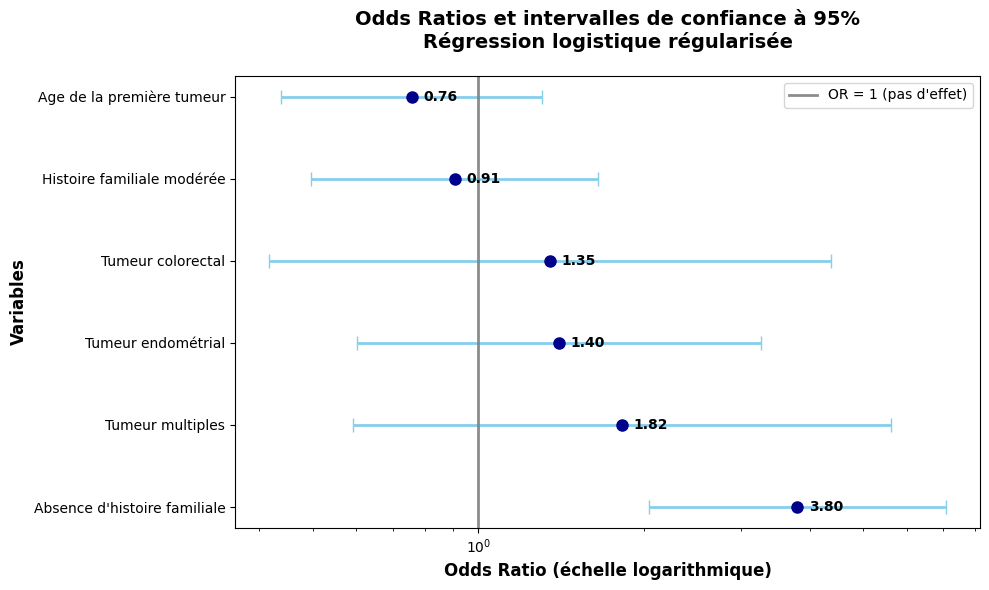

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# === Nouvelles données issues de la régression logistique ===
df = pd.DataFrame({
    "Variable": [
        "Age de la première tumeur",
        "Absence d'histoire familiale",
        "Histoire familiale modérée",
        "Tumeur colorectal",
        "Tumeur endométrial",
        "Tumeur multiples"
    ],
    "Coefficient": [ -0.2798, 1.3352, -0.0980, 0.2995, 0.3379, 0.6014],
    "CI_lower": [ -0.8270, 0.7134, -0.6983, -0.8765, -0.5061, -0.5250],
    "CI_upper": [ 0.2674, 1.9571, 0.5022, 1.4754, 1.1820, 1.7278]
})

# === Calcul des Odds Ratios et intervalles de confiance ===
df["OR"] = np.exp(df["Coefficient"])
df["OR_lower"] = np.exp(df["CI_lower"])
df["OR_upper"] = np.exp(df["CI_upper"])

# Trier par OR décroissant pour le graphique
df = df.sort_values("OR", ascending=False).reset_index(drop=True)

# === Création du forest plot ===
plt.figure(figsize=(10, 6))

plt.errorbar(df["OR"], df["Variable"], 
             xerr=[df["OR"] - df["OR_lower"], df["OR_upper"] - df["OR"]],
             fmt='o', color='darkblue', ecolor='skyblue',
             elinewidth=2, capsize=5, markersize=8)

# Ligne de référence OR=1
plt.axvline(x=1, color='grey', linestyle='-', alpha=0.9, linewidth=2, label="OR = 1 (pas d'effet)")

# Ajouter les valeurs des OR à côté des points
for i, or_val in enumerate(df["OR"]):
    plt.text(or_val * 1.05, i, f"{or_val:.2f}", 
             va='center', fontsize=10, fontweight='bold', color="black")

# Titres et labels
plt.title("Odds Ratios et intervalles de confiance à 95%\nRégression logistique régularisée", 
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel("Odds Ratio (échelle logarithmique)", fontsize=12, fontweight='bold')
plt.ylabel("Variables", fontsize=12, fontweight='bold')
plt.xscale("log")

plt.legend(fontsize=10)
plt.tight_layout()
plt.show()



RÉCAPITULATIF DES RÉSULTATS - RÉGRESSION LOGISTIQUE
                    Variable  Coefficient    OR        IC 95%  p_value Significativité
   Age de la première tumeur       -0.280 0.756 [0.44 - 1.31]    0.316              NS
  Histoire familiale modérée       -0.098 0.907 [0.50 - 1.65]    0.749              NS
           Tumeur colorectal        0.299 1.349 [0.42 - 4.37]    0.618              NS
          Tumeur endométrial        0.338 1.402 [0.60 - 3.26]    0.433              NS
            Tumeur multiples        0.601 1.825 [0.59 - 5.63]    0.295              NS
Absence d'histoire familiale        1.335 3.801 [2.04 - 7.08]    0.000               *

🔍 VARIABLE(S) SIGNIFICATIVE(S) :
--------------------------------------------------
• Absence d'histoire familiale : OR = 3.80 (augmente le risque d'être méthylé)
  p-value = 0.000


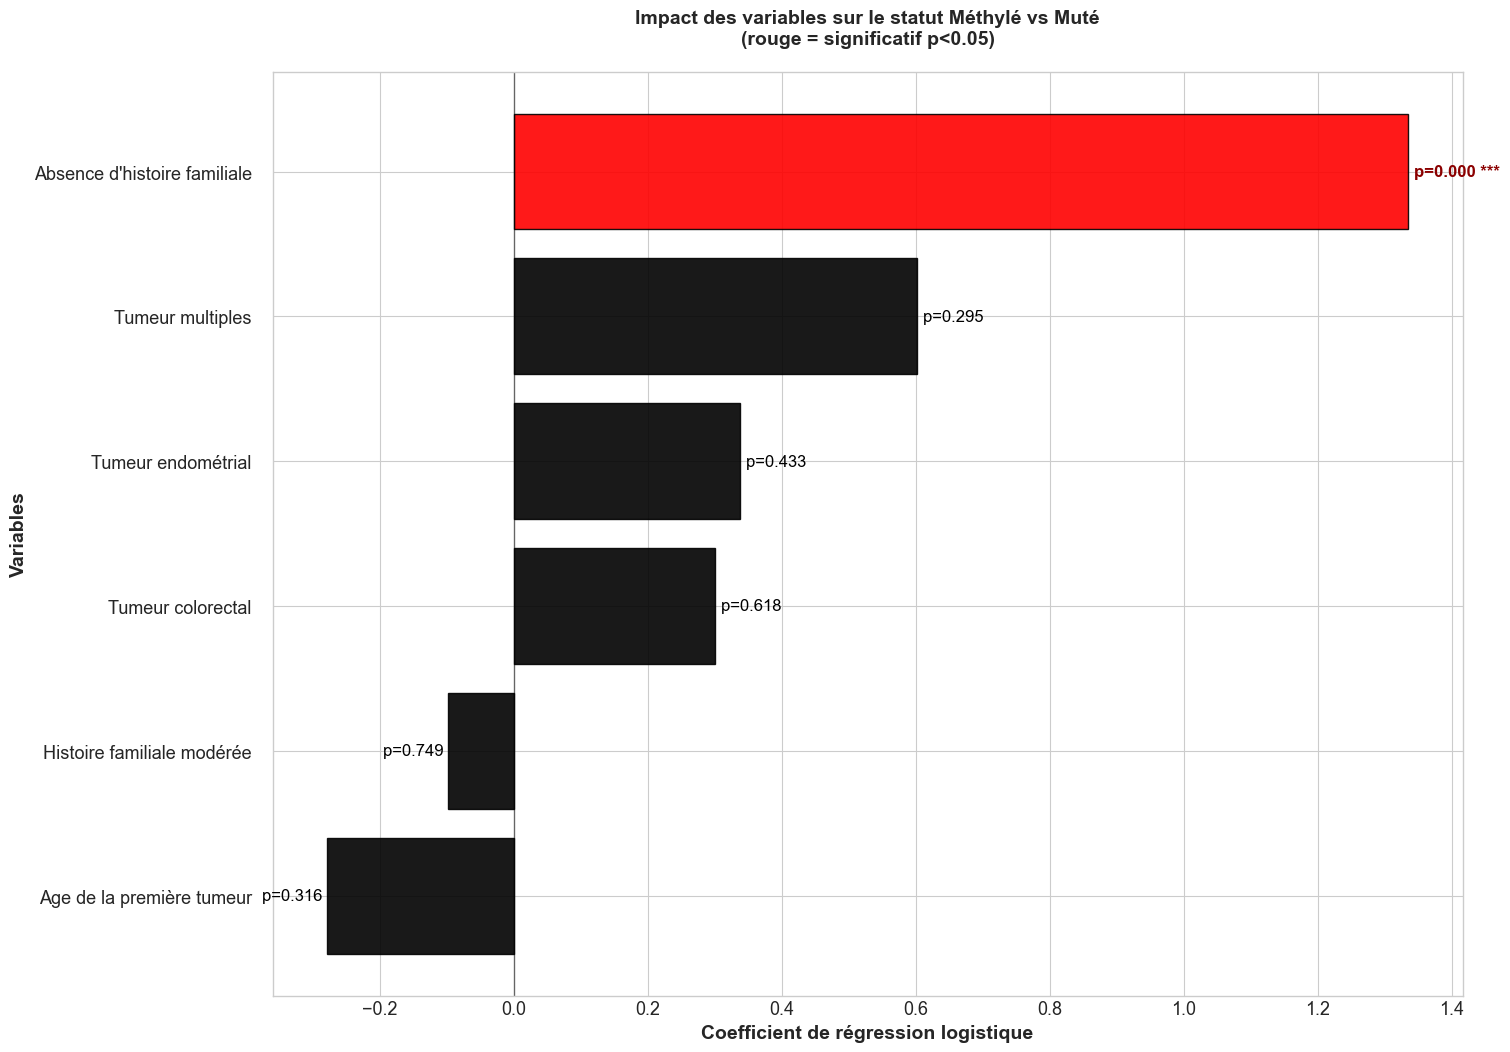

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# === Nouvelles données issues de la régression logistique ===
df = pd.DataFrame({
    "Variable": [
        "Age de la première tumeur",
        "Absence d'histoire familiale",
        "Histoire familiale modérée",
        "Tumeur colorectal",
        "Tumeur endométrial",
        "Tumeur multiples"
    ],
    "Coefficient": [ -0.2798, 1.3352, -0.0980, 0.2995, 0.3379, 0.6014],
    "CI_lower": [ -0.8270, 0.7134, -0.6983, -0.8765, -0.5061, -0.5250],
    "CI_upper": [ 0.2674, 1.9571, 0.5022, 1.4754, 1.1820, 1.7278],
    "p_value": [ 0.3162, 0.000026, 0.7489, 0.6177, 0.4326, 0.2953]  # p-values mises à jour
})

# === Configuration du style ===
plt.figure(figsize=(17, 12))
plt.style.use('seaborn-v0_8-whitegrid')

# Trier par coefficient pour une meilleure lisibilité
df = df.sort_values('Coefficient', ascending=True)

# Couleurs selon la significativité
colors = ['red' if p < 0.05 else 'black' for p in df['p_value']]

# === Création du plot des coefficients ===
bars = plt.barh(df['Variable'], df['Coefficient'], 
                color=colors, alpha=0.9, edgecolor='black', linewidth=1)

# Ajouter les p-values et symboles de significativité
for i, (coef, p_val) in enumerate(zip(df['Coefficient'], df['p_value'])):
    # Déterminer le symbole de significativité
    if p_val < 0.001:
        symbol = '***'
    elif p_val < 0.01:
        symbol = '**' 
    elif p_val < 0.05:
        symbol = '*'
    else:
        symbol = ''
    
    # Position du texte
    text_x = coef + (0.009 if coef >= 0 else -0.00000001)
    ha = 'left' if coef >= 0 else 'right'
    
    # Ajouter le texte
    plt.text(text_x, i, f'p={p_val:.3f} {symbol}', 
             va='center', ha=ha, fontweight='bold' if p_val < 0.05 else 'normal',
             color='darkred' if p_val < 0.05 else 'black', fontsize=12)

# Ligne verticale à zéro
plt.axvline(x=0, color='black', linestyle='-', alpha=0.5, linewidth=1)

# === Personnalisation ===
plt.subplots_adjust(left=0.2)
plt.xlabel('Coefficient de régression logistique', fontsize=14, fontweight='bold')
plt.ylabel('Variables', fontsize=14, fontweight='bold')
plt.title('Impact des variables sur le statut Méthylé vs Muté\n(rouge = significatif p<0.05)', 
          fontsize=14, fontweight='bold', pad=20)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

# Récupérer l'axe courant
ax = plt.gca()
ax.tick_params(axis='y', pad=15)

# === Affichage du tableau récapitulatif ===
print("="*80)
print("RÉCAPITULATIF DES RÉSULTATS - RÉGRESSION LOGISTIQUE")
print("="*80)

summary_df = df.copy()
summary_df['OR'] = np.exp(summary_df['Coefficient'])
summary_df['IC 95%'] = summary_df.apply(
    lambda x: f"[{np.exp(x['CI_lower']):.2f} - {np.exp(x['CI_upper']):.2f}]", axis=1
)
summary_df['Significativité'] = summary_df['p_value'].apply(
    lambda x: '*' if x < 0.001 else '*' if x < 0.01 else '*' if x < 0.05 else 'NS'
)

final_table = summary_df[['Variable', 'Coefficient', 'OR', 'IC 95%', 'p_value', 'Significativité']]
print(final_table.to_string(index=False, float_format=lambda x: f'{x:.3f}'))

# === Focus sur la variable significative ===
significant_vars = df[df['p_value'] < 0.05]
if not significant_vars.empty:
    print("\n" + "🔍 VARIABLE(S) SIGNIFICATIVE(S) :")
    print("-" * 50)
    for _, row in significant_vars.iterrows():
        effect = "augmente" if row['Coefficient'] > 0 else "diminue"
        print(f"• {row['Variable']} : OR = {np.exp(row['Coefficient']):.2f} ({effect} le risque d'être méthylé)")
        print(f"  p-value = {row['p_value']:.3f}")
else:
    print("\nℹ️ Aucune variable significative au seuil p<0.05")


In [5]:
from sklearn.linear_model import LogisticRegression

# Univarié
for col in X.columns:
    model_uni = LogisticRegression().fit(X[[col]], y)
    print(col, model_uni.coef_[0][0])


age de la premiere tumeur -0.31020924484935924
Antécédants familiaux_pas d'histoire 2.2313895377144695
Antécédants familiaux_histoire modérée -1.2530579909430333
type_tumeur_simplifie_colon_seul -0.28022036733051453
type_tumeur_simplifie_endo_seul 0.19694131204881535
type_tumeur_simplifie_multiples 0.5088931653580301
